# Курсовой проект

In [116]:
#Загружаем библиотеки
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings

import os

In [117]:
warnings.filterwarnings('ignore')

In [118]:
matplotlib.rcParams.update({'font.size':14})

In [119]:
#Создаем переменные и присваиваем им значения путей к тестовому и тренировочному файлу 
train_path = '../k_task/train.csv'
test_path =  '../k_task/test.csv'

In [120]:
#Читаем файл с тестовыми данными
test_df = pd.read_csv(test_path)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [121]:
#Читаем файл с тренировочными данными
train_df = pd.read_csv(train_path)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [122]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [123]:
#Приведение полей id и DistrictId к строкам
train_df['Id']=train_df['Id'].astype(str)
train_df['DistrictId']=train_df['DistrictId'].astype(str)

In [124]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]

target_mean, target_median, target_mode

(214138.86, 192269.64487934904, 59174.77802758122)

**- Строим диаграмму и смотрим распределение цен, а также выводим среднюю, медиану и моду**

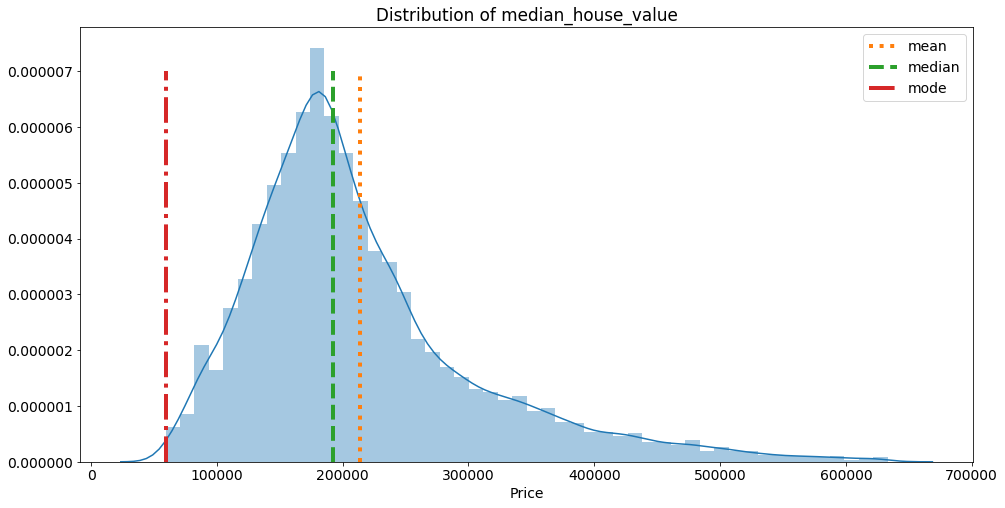

In [125]:


plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'])

y = np.linspace(0, 0.000007, 100)
plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of median_house_value')
plt.legend()
plt.show()

In [126]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [127]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

**- видим выбросы и хотя 10 и 19 могут быть неким элитным жильем, а ноль это квартира студия, пренебрегаем ими а также 5 и 6 и заполняем эти значения через медиану**

In [128]:
train_df.loc[train_df['Rooms'].isin([0,10,19,5,6]), 'Rooms'] = train_df['Rooms'].median()

In [129]:
train_df = train_df[train_df['Square'].isnull() | 
        (train_df['Square'] < train_df['Square'].quantile(.99)) & (train_df['Square'] > train_df['Square'].quantile(.01))]
train_df = train_df[train_df['LifeSquare'].isnull() | 
        (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.99)) 
         & (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.01))]
train_df = train_df[train_df['KitchenSquare'].isnull() | 
        (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.99)) 
         & (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.01))]

train_df.loc[train_df['HouseFloor'].isin([0,10,19,5]), 'HouseFloor'] = train_df['HouseFloor'].median()

**- применим законодательство РФ в котром сазано что кухня не меньше 5 и жилая не менее 14)))**

In [130]:
train_df.loc[train_df['Square'] < 14, 'Square'] = 14
train_df.loc[train_df['LifeSquare'] < 14, 'LifeSquare'] = 14
train_df.loc[(train_df['KitchenSquare'] < 5) & (train_df['KitchenSquare'] > 0), 'KitchenSquare'] = 5

In [131]:
#Выбросы по годам так же заполняем медианой
train_df.loc[train_df['HouseYear'].isin([20052011 ,4968]), 'HouseYear'] = train_df['HouseYear'].median()


In [132]:
train_df['HouseYear'].sort_values(ascending=False)

4493    2020.0
1499    2020.0
585     2020.0
5701    2020.0
7076    2020.0
7459    2020.0
8253    2020.0
2493    2020.0
6735    2020.0
3357    2020.0
9674    2020.0
4376    2020.0
790     2020.0
3859    2020.0
3485    2020.0
918     2020.0
4053    2020.0
2877    2020.0
9864    2019.0
8838    2019.0
4345    2019.0
372     2019.0
8290    2019.0
5457    2019.0
9330    2019.0
7957    2019.0
2135    2019.0
2582    2019.0
2262    2019.0
8193    2019.0
         ...  
9370    1933.0
8685    1933.0
6846    1933.0
9506    1933.0
8163    1933.0
6208    1932.0
7163    1931.0
3443    1931.0
2588    1931.0
6277    1931.0
8207    1931.0
8055    1931.0
8381    1930.0
6630    1930.0
4949    1930.0
8951    1929.0
3933    1929.0
9825    1928.0
7562    1919.0
2608    1919.0
4904    1919.0
1386    1918.0
5016    1918.0
8505    1918.0
2554    1918.0
1380    1917.0
8144    1917.0
5053    1917.0
7611    1916.0
910     1914.0
Name: HouseYear, Length: 8881, dtype: float64

**- Далее видим , что "Healthcare_1" по хорошему надо выкинуть. Проверяем с заполненными значениями по медиане и R2 = .945, удаляем и R2 опускается до .92. Возвращаемся к медиане.**

In [133]:
len(train_df) -  train_df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1585
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4082
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [134]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df['LifeSquare'].median()
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [135]:
# Проверяем поля ниже и все они категориальные из 2х категорий, замаеняем их на 0 и 1.
train_df['Shops_2'].value_counts()

B    8254
A     627
Name: Shops_2, dtype: int64

In [136]:
train_df['Ecology_2'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2'] = train_df['Shops_2'].replace({'A':0, 'B':1})

**- Далее создаем переменные с именами измерений и показателей**

In [ ]:
feature_name = [i for i in train_df.columns.to_list() if i not in ['Price']]
target_name = 'Price'

**- Тренируем модели и и проверяем их**

In [139]:
X = train_df[feature_name]
y = train_df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

rf_model = RandomForestRegressor(random_state=21)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=21, verbose=0,
                      warm_start=False)

In [140]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

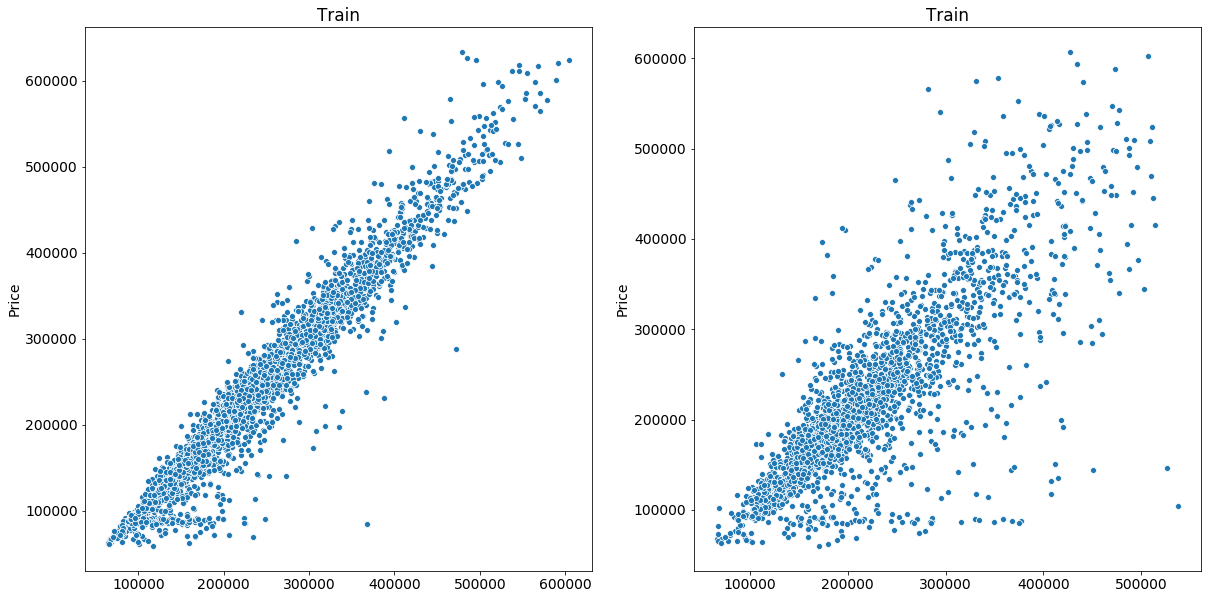

In [141]:
plt.figure(figsize=(20,10))

plt.subplot(121)
sns.scatterplot(x = y_train_preds, y = y_train)
plt.title('Train')

plt.subplot(122)
sns.scatterplot(x = y_test_preds, y = y_test)
plt.title('Train')

plt.show()


In [142]:
print(f'R2 train : {r2(y_train, y_train_preds)}')
print(f'R2 test : {r2(y_test, y_test_preds)}')

R2 train : 0.945428382485831
R2 test : 0.6640764684560605


In [149]:
y_train.to_frame().to_csv('../k_task/VRozhnov_predictions.csv')